In [ ]:
!pip install rasterstats
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 7.5 MB/s eta 0:00:00


In [ ]:
!pip install rasterstats
!pip install rasterio
import rasterio
import numpy as np
import glob
import os
from datetime import datetime

# 指定Google Drive路径（根据实际路径修改）
folder_path = "/content/drive/MyDrive/GEE_NDVI_VCI_Output"

# 获取所有TCI文件并按时间排序
file_list = glob.glob(os.path.join(folder_path, 'VCI_*.tif'))

# 自定义排序函数：从文件名提取年份和月份
def extract_date(file_path):
    filename = os.path.basename(file_path)
    year_month = filename.split('_')[1:3]  # 格式 ['YYYY', 'M.tif']
    year = int(year_month[0])
    month = int(year_month[1].split('.')[0])
    return (year, month)

# 按时间顺序排序文件
file_list.sort(key=extract_date)

# 遍历处理文件
for file in file_list:
    try:
        with rasterio.open(file) as src:
            data = src.read(1)
            # 过滤无效值（假设NoData值为-32768）
            data = np.where(data == src.nodata, np.nan, data)

            print(f"{os.path.basename(file):<20}",
                  f"Date: {extract_date(file)[0]}-{extract_date(file)[1]:02d}",
                  f"Min: {np.nanmin(data):7.2f}",
                  f"Max: {np.nanmax(data):7.2f}")

    except Exception as e:
        print(f"无法读取文件 {file}，错误：{str(e)}")

VCI_2000_03.tif      Date: 2000-03 Min:    0.00 Max:  100.00
VCI_2000_04.tif      Date: 2000-04 Min:    0.00 Max:  100.00
VCI_2000_05.tif      Date: 2000-05 Min:    0.00 Max:  100.00
VCI_2000_06.tif      Date: 2000-06 Min:    0.00 Max:  100.00
VCI_2000_07.tif      Date: 2000-07 Min:    0.00 Max:  100.00
VCI_2000_08.tif      Date: 2000-08 Min:    0.00 Max:  100.00
VCI_2000_09.tif      Date: 2000-09 Min:    0.00 Max:  100.00
VCI_2000_10.tif      Date: 2000-10 Min:    0.00 Max:  100.00
VCI_2000_11.tif      Date: 2000-11 Min:    0.00 Max:  100.00
VCI_2000_12.tif      Date: 2000-12 Min:    0.00 Max:  100.00
VCI_2001_01.tif      Date: 2001-01 Min:    0.00 Max:  100.00
VCI_2001_02.tif      Date: 2001-02 Min:    0.00 Max:  100.00
VCI_2001_03.tif      Date: 2001-03 Min:    0.00 Max:  100.00
VCI_2001_04.tif      Date: 2001-04 Min:    0.00 Max:  100.00
VCI_2001_05.tif      Date: 2001-05 Min:    0.00 Max:  100.00
VCI_2001_06.tif      Date: 2001-06 Min:    0.00 Max:  100.00
VCI_2001_07.tif      Dat

In [ ]:

import os
import glob
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd

# 1. 读取摩洛哥省级边界 shapefile
# 注意：shapefile 路径根据实际情况修改
shp_path = '/content/drive/MyDrive/shp/final map/MAR.shp'
gdf = gpd.read_file(shp_path)

# 2. 列出所有 VCI 文件（假设命名格式为 VCI_YYYY_MM.tif）
tif_files = sorted(glob.glob('/content/drive/MyDrive/GEE_NDVI_VCI_Output/VCI_*.tif'))

# 用于存放结果的列表
results = []

# 3. 循环处理每一个 tif 文件
for tif in tif_files:
    # 从文件名中提取年份和月份信息，如 "VCI_2000_10.tif"
    base = os.path.basename(tif)
    name_parts = base.replace('.tif', '').split('_')
    year = name_parts[1]
    month = name_parts[2]

    # 计算每个省内的平均 VCI 值
    # 注意：根据数据情况可能需要指定 nodata 值，例如 nodata=-9999
    stats = zonal_stats(gdf, tif, stats='mean', nodata=-9999)

    # 将每个省份的统计结果添加到结果列表中
    for idx, stat in enumerate(stats):
        # 假设省份名称存储在 gdf 的某个字段中（例如 "NAME_2"），请根据实际情况调整字段名称
        province_name = gdf.iloc[idx]['NAME_2'] if 'NAME_2' in gdf.columns else gdf.iloc[idx]['NAME']
        results.append({
            'Province': province_name,
            'Year': year,
            'Month': month,
            'VCI_mean': stat['mean']
        })

# 4. 整理结果为 DataFrame
df = pd.DataFrame(results)

# 如有需要，可以将结果导出为 CSV 文件
output_csv = '/content/drive/MyDrive/VCI_monthly_by_province.csv'
df.to_csv(output_csv, index=False)
print("结果已保存到:", output_csv)


结果已保存到: /content/drive/MyDrive/VCI_monthly_by_province.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 加载SMCI数据
df = pd.read_csv("/content/drive/MyDrive/VCI_monthly_by_province.csv")

# 转换日期格式
df['Date'] = pd.to_datetime(
    df['Year'].astype(str) + '-' +
    df['Month'].astype(str).str.zfill(2) + '-01'
)

# 按省份和日期排序
df = df.sort_values(by=['Province', 'Date'])

# 配置绘图参数
provinces = df['Province'].unique()
n_provinces = len(provinces)
cols = 3
rows = (n_provinces + cols - 1) // cols

# 创建子图网格
fig, axes = plt.subplots(
    rows, cols,
    figsize=(18, 3.5*rows),  # 调整尺寸适应更多省份
    sharex=True,
    sharey=True,
    constrained_layout=True
)

# 设置统一坐标轴范围
vmin = df['VCI_mean'].quantile(0.05)
vmax = df['VCI_mean'].quantile(0.95)

# 绘制每个省份的时间序列
for ax, province in zip(axes.flatten(), provinces):
    # 筛选数据
    mask = df['Province'] == province
    province_df = df[mask].copy()

    # 计算12月滑动平均
    province_df['12m_MA'] = province_df['VCI_mean'].rolling(window=12, min_periods=1).mean()

    # 绘制原始值和滑动平均
    ax.plot(province_df['Date'], province_df['VCI_mean'],
            color='#1f77b4', alpha=0.3, label='Monthly')
    ax.plot(province_df['Date'], province_df['12m_MA'],
            linewidth=1.5, color='#d62728', label='12-M MA')

    # 设置子图元素
    ax.set_title(province, fontsize=10, pad=4)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(vmin, vmax)

    # 设置时间轴格式
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45, labelsize=8)

# 隐藏多余子图
for ax in axes.flatten()[n_provinces:]:
    ax.set_visible(False)

# 添加全局元素
fig.suptitle('Provincial VCI Time Series (2000-2023)',
            y=1.02, fontsize=14, fontweight='bold')
fig.text(0.5, -0.02, 'Year', ha='center', fontsize=12)
fig.text(-0.02, 0.5, 'Soil Moisture Condition Index',
        va='center', rotation='vertical', fontsize=12)

# 添加图例
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
          loc='upper center',
          ncol=2,
          bbox_to_anchor=(0.5, 1.06),
          frameon=False)

# 保存输出
output_path = "/content/drive/MyDrive/Provincial_VCI_Grid.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"成功生成多省份时序图：{output_path}")

成功生成多省份时序图：/content/drive/MyDrive/Provincial_VCI_Grid.png


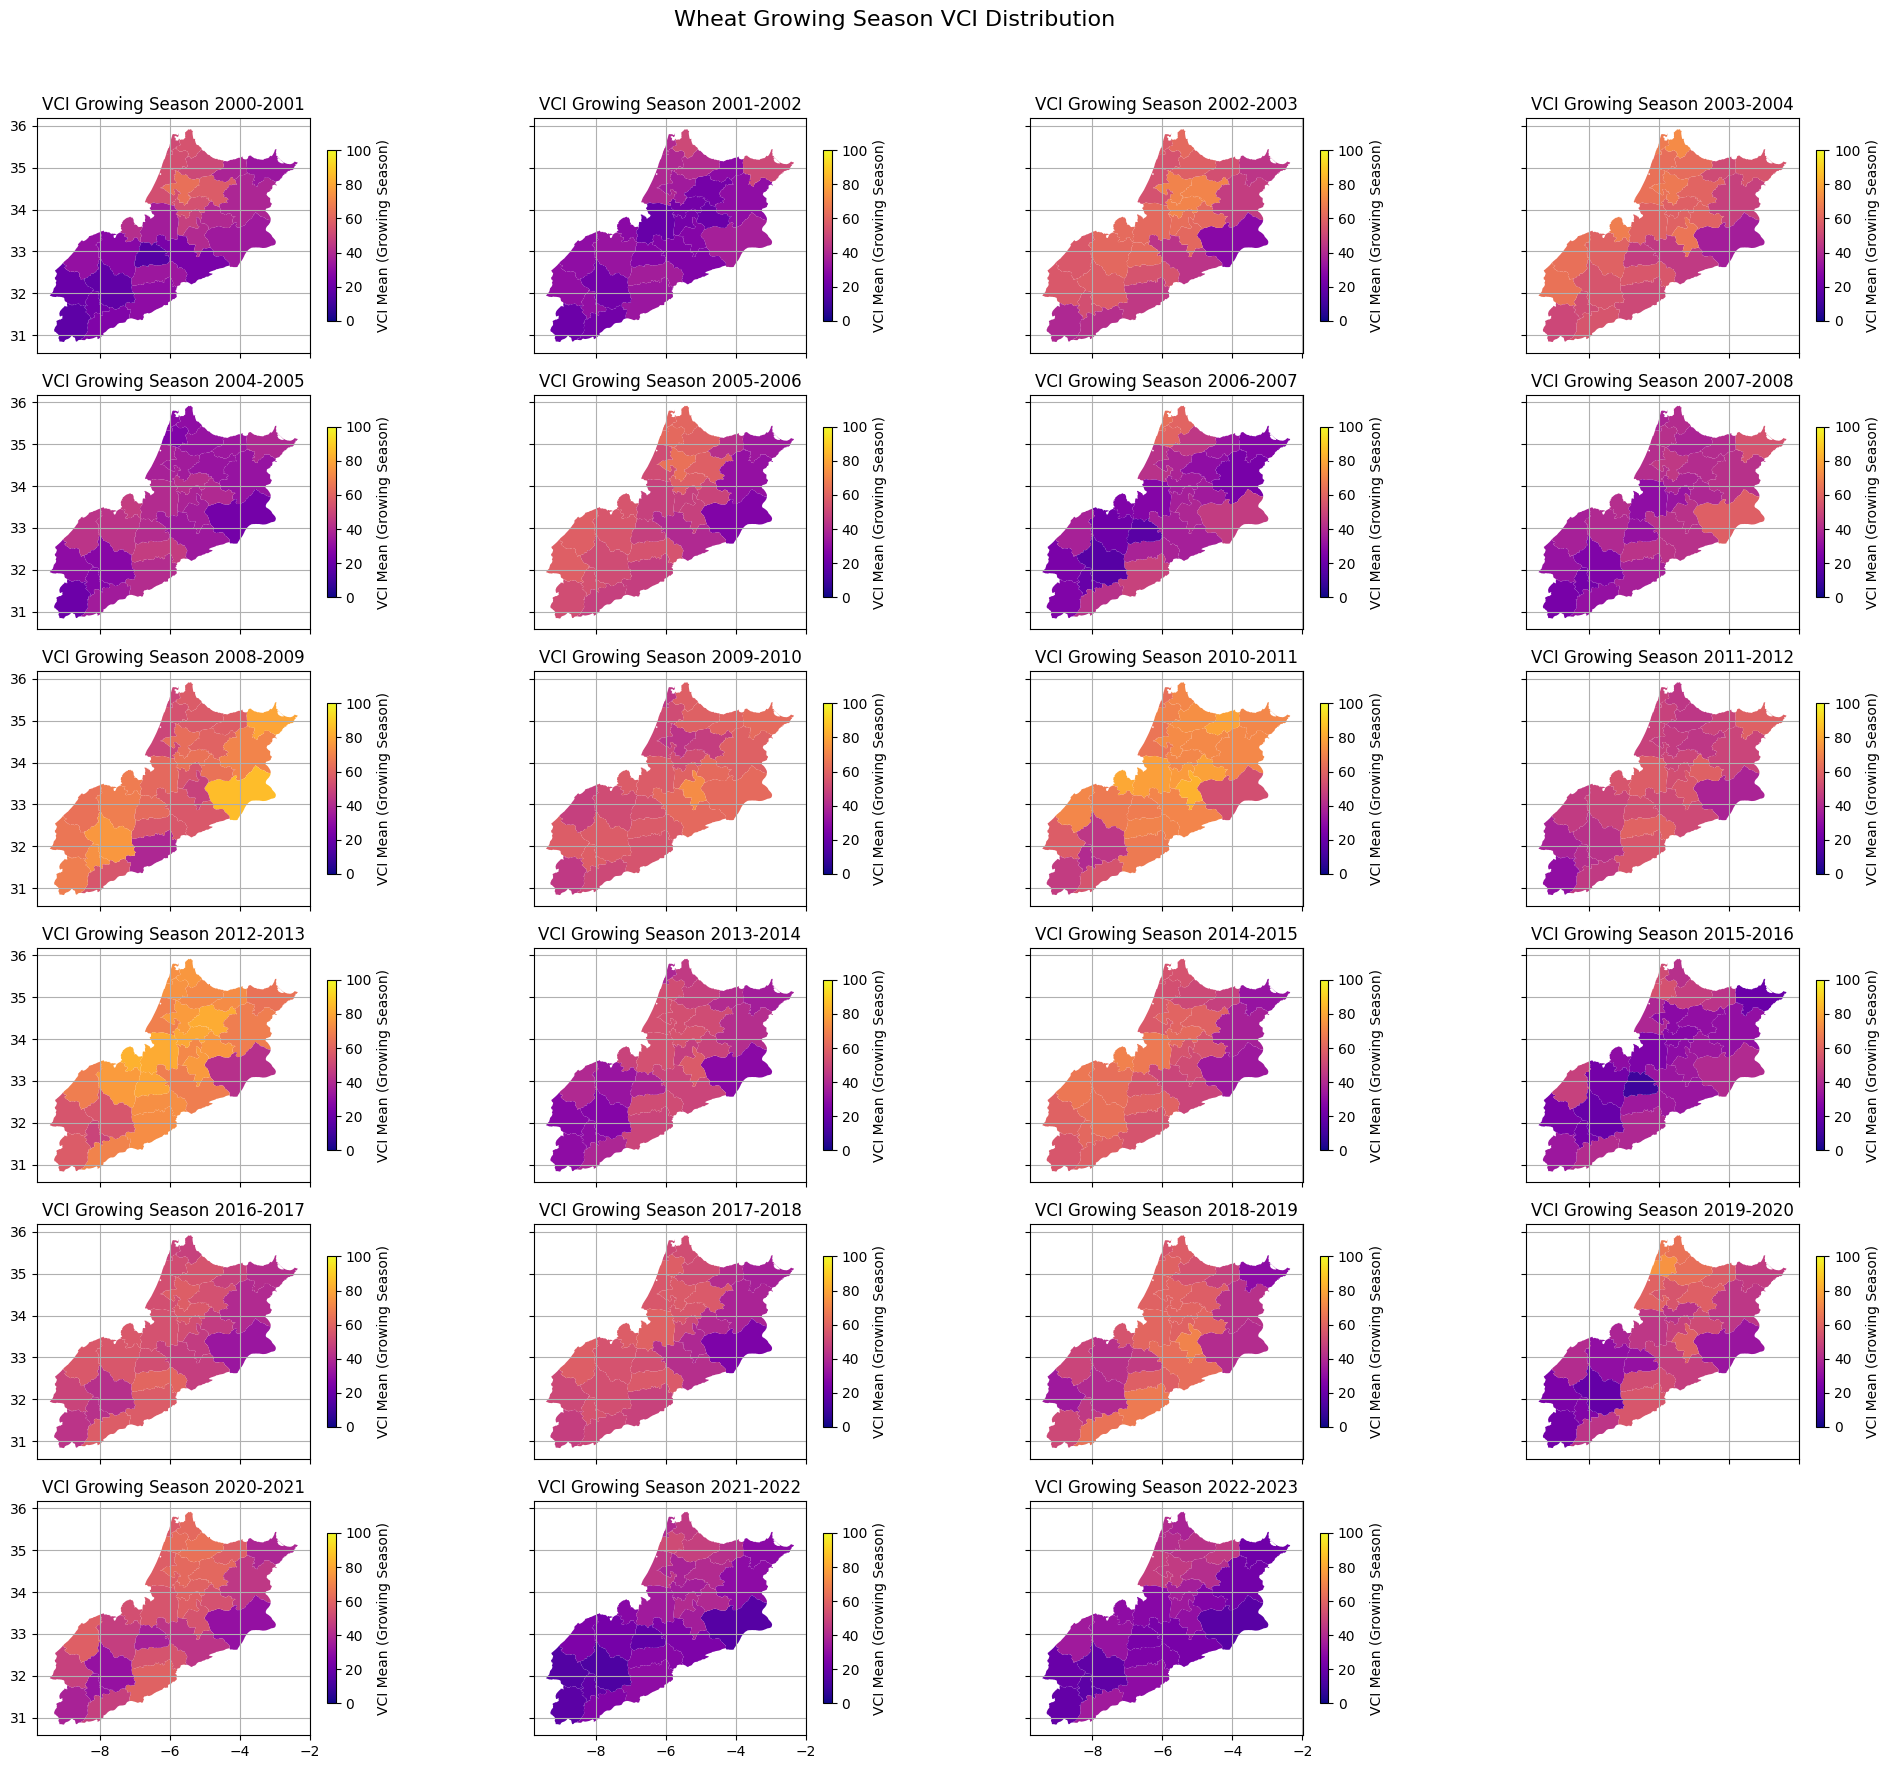

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 读取 Shapefile
shapefile_path = "/content/drive/MyDrive/shp/final map/MAR.shp"
gdf = gpd.read_file(shapefile_path)

# 读取 TCI 数据
tci_csv_path = "/content/drive/MyDrive/VCI_monthly_by_province.csv"
tci_df = pd.read_csv(tci_csv_path)

# 将 'Year' 和 'Month' 列转换为整数类型
tci_df['Year'] = tci_df['Year'].astype(int)
tci_df['Month'] = tci_df['Month'].astype(int)

# 计算生长季的 TCI 平均值（11月至6月）
tci_df['Growing_Season_Year'] = tci_df.apply(lambda row: row['Year'] if row['Month'] >= 11 else row['Year'] - 1, axis=1)

# 筛选生长季（11月到6月）
growing_season_df = tci_df[tci_df['Month'].isin([11, 12, 1, 2, 3, 4, 5, 6])]

# 计算生长季的年度平均 TCI
seasonal_avg_tci_df = growing_season_df.groupby(['Province', 'Growing_Season_Year'])['VCI_mean'].mean().reset_index()
seasonal_avg_tci_df.rename(columns={'Growing_Season_Year': 'Year'}, inplace=True)

# 合并 Shapefile 数据和计算出的生长季 TCI
gdf = gdf.merge(seasonal_avg_tci_df, left_on='NAME_2', right_on='Province', how='left')

# 获取2000/2001到2022/2023的年份范围
years = [year for year in range(2000, 2023)]

# 设置颜色映射范围
vmin, vmax = 0, 100

# 根据每行 4 个图来设置子图网格
cols = 4
rows = (len(years) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=True, sharey=True)

# 绘制每年的生长季 TCI 数据
for i, year in enumerate(years):
    ax = axes.flatten()[i]  # 获取对应的子图
    year_data = gdf[gdf['Year'] == year]

    # 确保数据没有缺失值
    if year_data['VCI_mean'].isnull().sum() > 0:
        print(f"Warning: Missing data for growing season {year}.")

    # 统一颜色范围 (vmin=0, vmax=100)
    year_data.plot(column='VCI_mean', ax=ax, legend=True, cmap='plasma',
                   vmin=vmin, vmax=vmax,
                   legend_kwds={'label': "VCI Mean (Growing Season)", 'orientation': 'vertical', 'fraction': 0.02, 'pad': 0.04})

    ax.set_title(f"VCI Growing Season {year}-{year+1}")
    ax.grid(True)

# 隐藏多余的子图
for ax in axes.flatten()[len(years):]:
    ax.set_visible(False)

fig.suptitle("Wheat Growing Season VCI Distribution", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



<ipython-input-2-89b2b659ca1f>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # 调整布局以留出颜色条空间


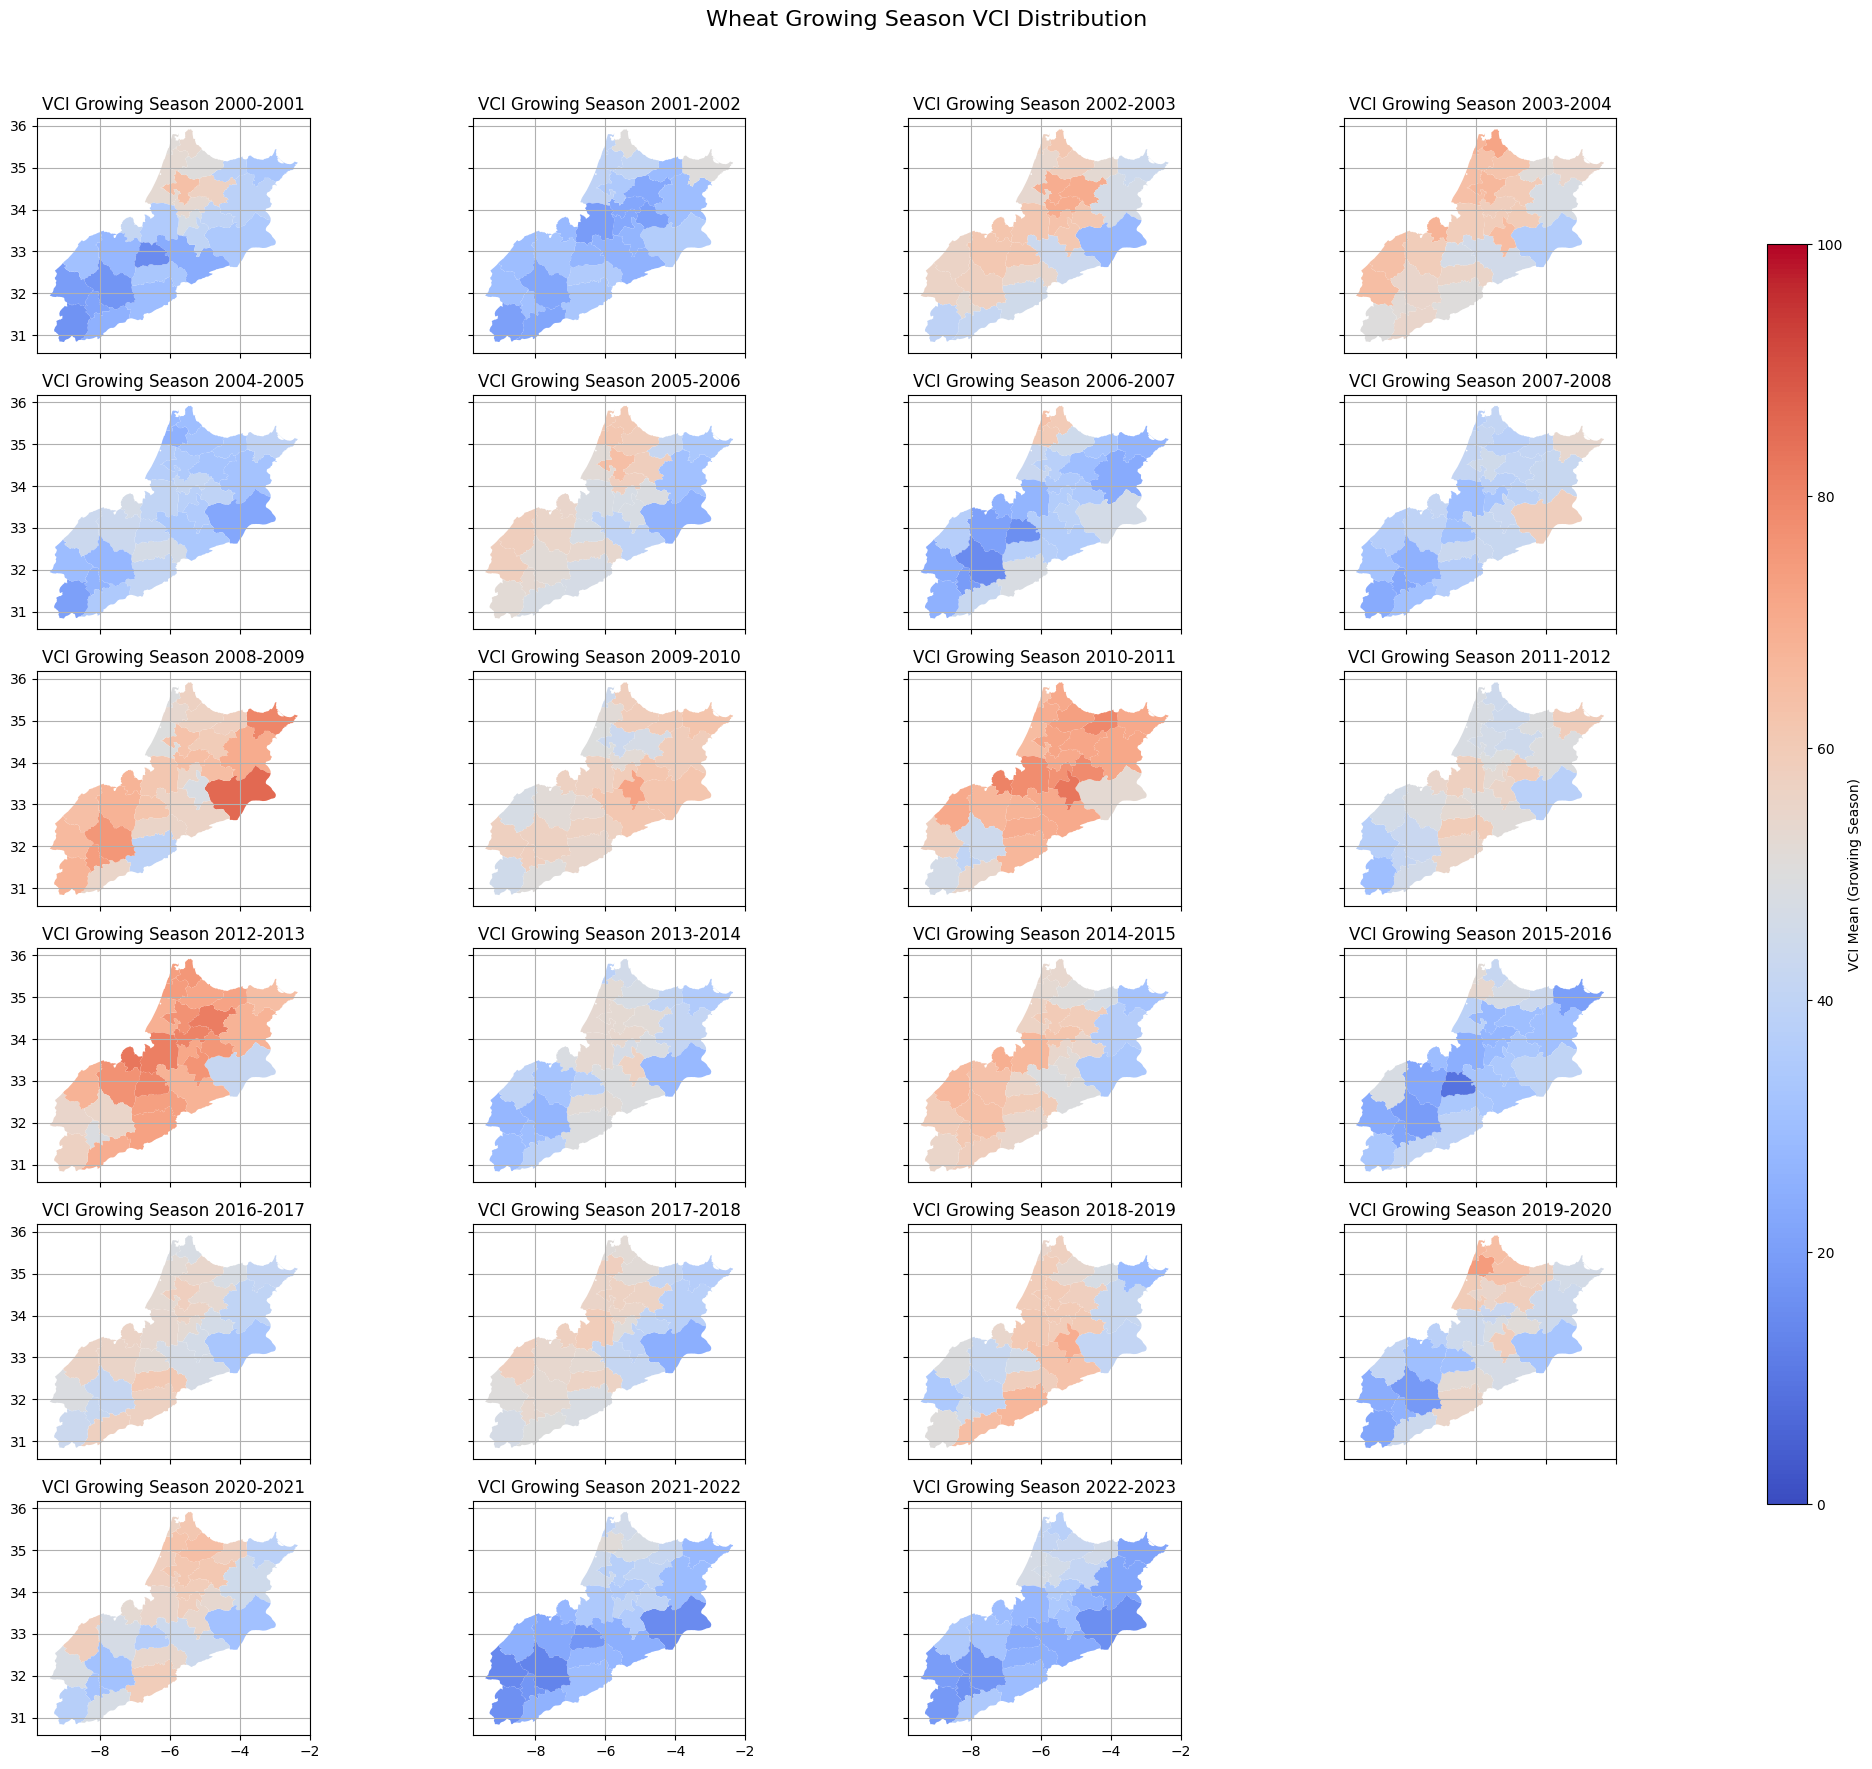

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 读取 Shapefile
shapefile_path = "/content/drive/MyDrive/shp/final map/MAR.shp"
gdf = gpd.read_file(shapefile_path)

# 读取 TCI 数据
tci_csv_path = "/content/drive/MyDrive/table/VCI_monthly_by_province.csv"
tci_df = pd.read_csv(tci_csv_path)

# 将 'Year' 和 'Month' 列转换为整数类型
tci_df['Year'] = tci_df['Year'].astype(int)
tci_df['Month'] = tci_df['Month'].astype(int)

# 计算生长季的 TCI 平均值（11月至6月）
tci_df['Growing_Season_Year'] = tci_df.apply(lambda row: row['Year'] if row['Month'] >= 11 else row['Year'] - 1, axis=1)

# 筛选生长季（11月到6月）
growing_season_df = tci_df[tci_df['Month'].isin([11, 12, 1, 2, 3, 4, 5, 6])]

# 计算生长季的年度平均 TCI
seasonal_avg_tci_df = growing_season_df.groupby(['Province', 'Growing_Season_Year'])['VCI_mean'].mean().reset_index()
seasonal_avg_tci_df.rename(columns={'Growing_Season_Year': 'Year'}, inplace=True)

# 合并 Shapefile 数据和计算出的生长季 TCI
gdf = gdf.merge(seasonal_avg_tci_df, left_on='NAME_2', right_on='Province', how='left')

# 获取2000/2001到2022/2023的年份范围
years = [year for year in range(2000, 2023)]

# 设置颜色映射
tci_vmin, tci_vmax = 0, 100
cmap = 'coolwarm'
norm = mcolors.Normalize(vmin=tci_vmin, vmax=tci_vmax)

# 设置子图布局
cols = 4
rows = (len(years) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=True, sharey=True)

# 绘制每年的生长季 TCI 数据
for i, year in enumerate(years):
    ax = axes.flatten()[i]  # 获取对应的子图
    year_data = gdf[gdf['Year'] == year]

    if year_data.empty:
        ax.set_visible(False)
        continue

    year_data.plot(column='VCI_mean', ax=ax, cmap=cmap, norm=norm, legend=False)
    ax.set_title(f"VCI Growing Season {year}-{year+1}")
    ax.grid(True)

# 隐藏多余的子图
for ax in axes.flatten()[len(years):]:
    ax.set_visible(False)

# 添加全局颜色条
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # 颜色条位置调整
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, cax=cbar_ax, label='VCI Mean (Growing Season)')

fig.suptitle("Wheat Growing Season VCI Distribution", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # 调整布局以留出颜色条空间
plt.show()

In [ ]:

!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
import glob
import re
from datetime import datetime, timedelta

# Google Drive 挂载
from google.colab import drive
drive.mount('/content/drive')

# 设置数据目录
ndvi_dir = "/content/drive/MyDrive/GEE_NDVI"
output_dir = "/content/drive/MyDrive/GEE_NDVI_VCI_Output"
os.makedirs(output_dir, exist_ok=True)

# 自定义DOY转月份函数
def doy_to_month(year, doy):
    date = datetime(year, 1, 1) + timedelta(days=doy-1)
    return date.month

# 解析文件名，获取年份和月份
pattern = re.compile(r"doy(\d{4})(\d{3})")  # 匹配 YYYYDDD
ndvi_files = sorted(glob.glob(os.path.join(ndvi_dir, "*.tif")))

# 创建字典 {月份: [文件列表]}
ndvi_by_month = {m: [] for m in range(1, 13)}

for f in ndvi_files:
    match = pattern.search(f)
    if match:
        year, doy = int(match.group(1)), int(match.group(2))
        month = doy_to_month(year, doy)
        ndvi_by_month[month].append((year, f))

# 修改后的关键代码段

# 计算多年 NDVI 最值
ndvi_min, ndvi_max = {}, {}

for month in range(1, 13):
    files = sorted(ndvi_by_month[month], key=lambda x: x[0])  # 列表元素为 (year, filepath)

    # 过滤时保留元组结构
    if month in [1, 2]:  # 1月和2月，去掉2000年
        files = [(y, f) for y, f in files if y >= 2001]
    else:  # 3月-12月，保留2000年数据
        files = [(y, f) for y, f in files]

    if not files:
        print(f"月份 {month} 无数据，跳过")
        continue

    # 读取所有 NDVI 影像并堆叠
    ndvi_stack = []
    # 正确访问第一个文件的路径：files[0][1]
    with rasterio.open(files[0][1]) as src:
        profile = src.profile
        profile.update(dtype=rasterio.float32, compress='lzw')
        height, width = src.shape

    # 使用内存映射文件减少内存占用
    ndvi_stack = np.memmap('temp.bin', dtype=np.float32, mode='w+', shape=(len(files), height, width))
    for i, (year, f) in enumerate(files):  # 正确解包元组
        with rasterio.open(f) as src:
            data = src.read(1).astype(np.float32)
            data[data == -3000] = np.nan  # 处理填充值
            ndvi_stack[i] = data

    # 计算 min 和 max（忽略NaN）
    ndvi_min[month] = np.nanmin(ndvi_stack, axis=0)
    ndvi_max[month] = np.nanmax(ndvi_stack, axis=0)
    del ndvi_stack  # 释放内存

# 计算 VCI 并保存
for filepath in ndvi_files:
    match = pattern.search(filepath)
    if not match:
        continue

    year, doy = int(match.group(1)), int(match.group(2))
    month = doy_to_month(year, doy)

    # 检查该月份是否有历史最值
    if month not in ndvi_min or month not in ndvi_max:
        print(f"跳过 {year}-{month:02d}，无历史最值数据")
        continue

    with rasterio.open(filepath) as src:
        ndvi = src.read(1).astype(np.float32)
        ndvi[ndvi == -3000] = np.nan  # 处理填充值

        # 计算VCI（处理分母为零）
        denominator = ndvi_max[month] - ndvi_min[month]
        denominator[denominator == 0] = 1e-6  # 避免除以零
        vci = ((ndvi - ndvi_min[month]) / denominator) * 100
        vci = np.clip(vci, 0, 100)

        # 输出文件
        output_file = os.path.join(output_dir, f"VCI_{year}_{month:02d}.tif")
        profile = src.profile
        profile.update(dtype=rasterio.float32, compress='lzw')

        with rasterio.open(output_file, "w", **profile) as dst:
            dst.write(vci.astype(np.float32), 1)

print("VCI 计算完成，已保存到:", output_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-16-f8d8496b128a>:72: RuntimeWarning: All-NaN axis encountered
  ndvi_min[month] = np.nanmin(ndvi_stack, axis=0)
<ipython-input-16-f8d8496b128a>:73: RuntimeWarning: All-NaN axis encountered
  ndvi_max[month] = np.nanmax(ndvi_stack, axis=0)


VCI 计算完成，已保存到: /content/drive/MyDrive/GEE_NDVI_VCI_Output


yield covariance

In [ ]:
import pandas as pd

# 读取数据
df = pd.read_table("/content/drive/MyDrive/Seasonal_VCI_Wide.xlsx")

# 省份名称映射
province_name_map = {
    "Al Hoceïma": "Al Hoceima",
    "Meknes": "Meknés",
    "Tanger-Assilah": "Tanger -Assilah",
    "El Kelaâ des Sraghna": "El Kelâa des Sraghna",
    "Fès": "Fes",
    "Al Haouz": "Al houze",
}

# 应用名称映射
df['Province'] = df['Province'].replace(province_name_map)

# 目标省份顺序
province_order = [
    "Al Hoceima", "Azilal", "Ben Slimane", "Boulemane", "Béni Mellal",
    "Chefchaouen", "Chichaoua", "El Hajeb", "El Jadida", "El Kelâa des Sraghna",
    "Fes", "Ifrane", "Khouribga", "Khémisset", "Khénifra", "Kénitra", "Larache",
    "Marrakech", "Meknés", "Nador", "Safi", "Settat", "Sidi Kacem",
    "Tanger -Assilah", "Taounate", "Taza", "Tétouan", "Al houze"
]

# 生成生长季年份（格式：2000/2001）
def get_season_year(row):
    if row['Month'] >= 11:
        return f"{row['Year']}/{row['Year'] + 1}"
    else:
        return f"{row['Year'] - 1}/{row['Year']}"

df['Season_Year'] = df.apply(get_season_year, axis=1)

# 筛选指定生长季范围（2000/2001 至 2022/2023）
valid_seasons = [f"{y}/{y+1}" for y in range(2000, 2023)]
df = df[df['Season_Year'].isin(valid_seasons)]

# 按生长季和省份计算均值，并转为宽表
season_vci = df.groupby(['Season_Year', 'Province'])['VCI_mean'].mean().unstack()

# 按目标省份顺序筛选列
season_vci = season_vci[province_order]

# 按生长季年份排序
season_vci = season_vci.sort_index(key=lambda x: x.str.split('/').str[0].astype(int))

# 保存结果
season_vci.to_csv("/content/drive/MyDrive/Seasonal_VCI_Wide.csv")


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x9d in position 54: invalid start byte

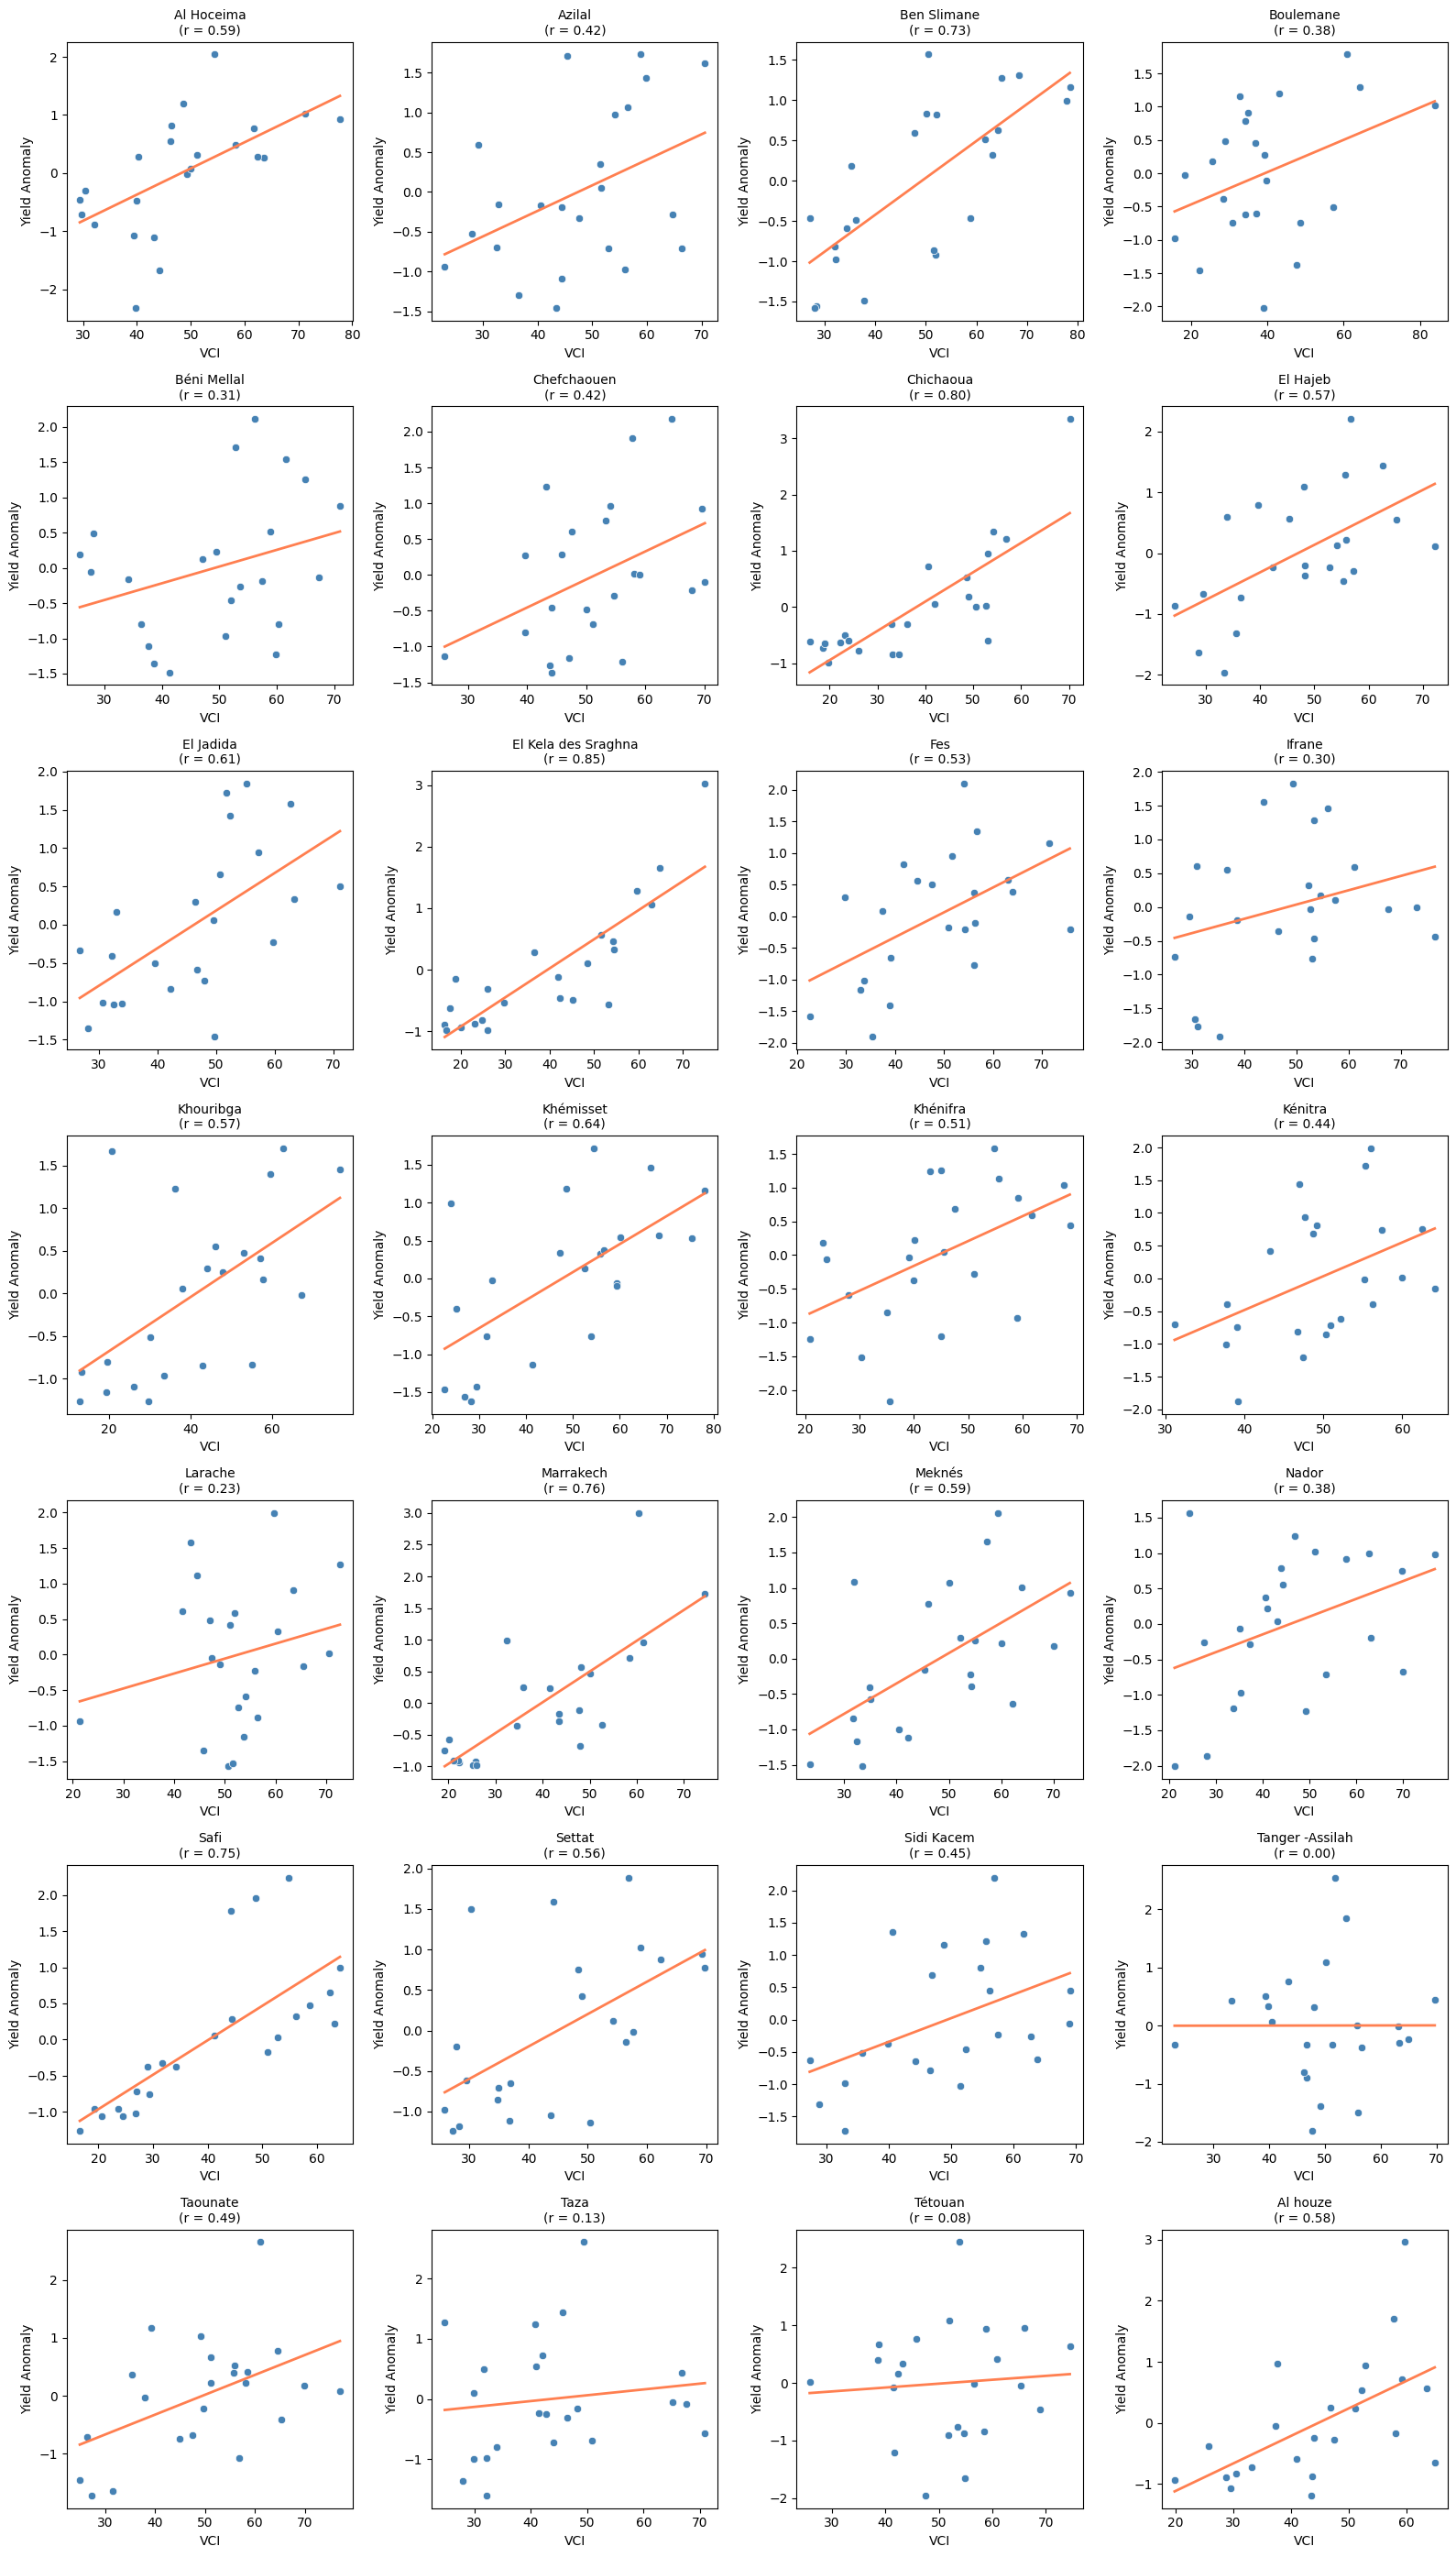

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# =============================================
# 1. 读取数据并预处理
# =============================================
# 读取VCI数据（省份为列，年份为索引）
vci = pd.read_excel("/content/drive/MyDrive/Seasonal_VCI_Wide.xlsx", index_col="Season_Year")

# 读取Anomaly Yield数据（省份为列，年份为索引）
anomaly = pd.read_excel("/content/drive/MyDrive/Anomaly_Yield_Results.xlsx", index_col="Season_Year")

# 确保省份顺序一致
province_order = vci.columns.tolist()
anomaly = anomaly[province_order]

# =============================================
# 2. 计算协方差和相关系数
# =============================================
# 初始化结果存储
cov_results = []
corr_results = []

# 遍历每个省份计算
for province in province_order:
    # 对齐数据
    combined = pd.DataFrame({
        'VCI': vci[province],
        'Anomaly': anomaly[province]
    }).dropna()

    # 计算统计量
    if not combined.empty:
        covariance = combined.cov().iloc[0, 1]
        correlation = combined.corr().iloc[0, 1]

        cov_results.append({'Province': province, 'Covariance': covariance})
        corr_results.append({'Province': province, 'Correlation': correlation})

# 转换为DataFrame
cov_df = pd.DataFrame(cov_results)
corr_df = pd.DataFrame(corr_results)

# 保存结果
cov_df.to_csv("/content/drive/MyDrive/VCI_Covariance_Results.csv", index=False)
corr_df.to_csv("/content/drive/MyDrive/VCI_Correlation_Results.csv", index=False)

# =============================================
# 3. 绘制所有省份的散点图+回归直线
# =============================================
num_provinces = len(province_order)  # 省份总数
cols = 4  # 每行最多显示 4 个图
rows = (num_provinces // cols) + (num_provinces % cols > 0)  # 计算总行数

plt.figure(figsize=(4 * cols, 4 * rows))  # 动态调整图的大小

for i, province in enumerate(province_order, 1):
    ax = plt.subplot(rows, cols, i)

    # 提取数据
    combined = pd.DataFrame({
        'VCI': vci[province],
        'Anomaly': anomaly[province]
    }).dropna()

    # 绘制散点图
    sns.scatterplot(data=combined, x='VCI', y='Anomaly', color='steelblue', ax=ax)

    # 添加回归线
    if not combined.empty:
        slope, intercept, r_value, p_value, std_err = linregress(
            combined['VCI'], combined['Anomaly']
        )
        sns.lineplot(
            x=combined['VCI'],
            y=slope * combined['VCI'] + intercept,
            color='coral',
            linewidth=2,
            ax=ax
        )
        ax.set_title(f"{province}\n(r = {r_value:.2f})", fontsize=10)

    # 设置坐标轴标签
    ax.set_xlabel("VCI")
    ax.set_ylabel("Yield Anomaly")

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/VCI_Scatter_Plots.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------------------------
# 1. 读取数据
# ---------------------------
yield_path = "/content/drive/MyDrive/table/Anomaly_Yield_Results.xlsx"
vci_path = "/content/drive/MyDrive/table/Seasonal_VCI_Wide.csv"

df_yield = pd.read_excel(yield_path).set_index('Season_Year')
df_vci = pd.read_csv(vci_path).set_index('Season_Year')

# 统一列名
df_yield.columns = df_yield.columns.str.strip()
df_vci.columns = df_vci.columns.str.strip()

# 获取所有省份名称（两个表的交集）
provinces = list(set(df_yield.columns) & set(df_vci.columns))

# ---------------------------
# 2. 绘制双轴时间序列图
# ---------------------------
save_dir = "/content/drive/MyDrive/output_plots"
os.makedirs(save_dir, exist_ok=True)  # 创建存储目录

for province in provinces:
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # 绘制Yield（左轴）
    ax1.plot(df_yield.index, df_yield[province], color='tab:blue', label='Yield Anomaly', marker='o', linestyle='-')
    ax1.set_xlabel("Season Year")
    ax1.set_ylabel("Yield Anomaly", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # 创建右轴并绘制VCI
    ax2 = ax1.twinx()
    ax2.plot(df_vci.index, df_vci[province], color='tab:red', label='VCI', marker='s', linestyle='--')
    ax2.set_ylabel("VCI", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # 添加标题和图例
    plt.title(f"Yield Anomaly & VCI Trend in {province}")
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # 保存图片
    plt.savefig(f"{save_dir}/{province}_Yield_VCI.png", dpi=300, bbox_inches='tight')
    plt.close()

print(f"所有图已保存至 {save_dir}")


所有图已保存至 /content/drive/MyDrive/output_plots


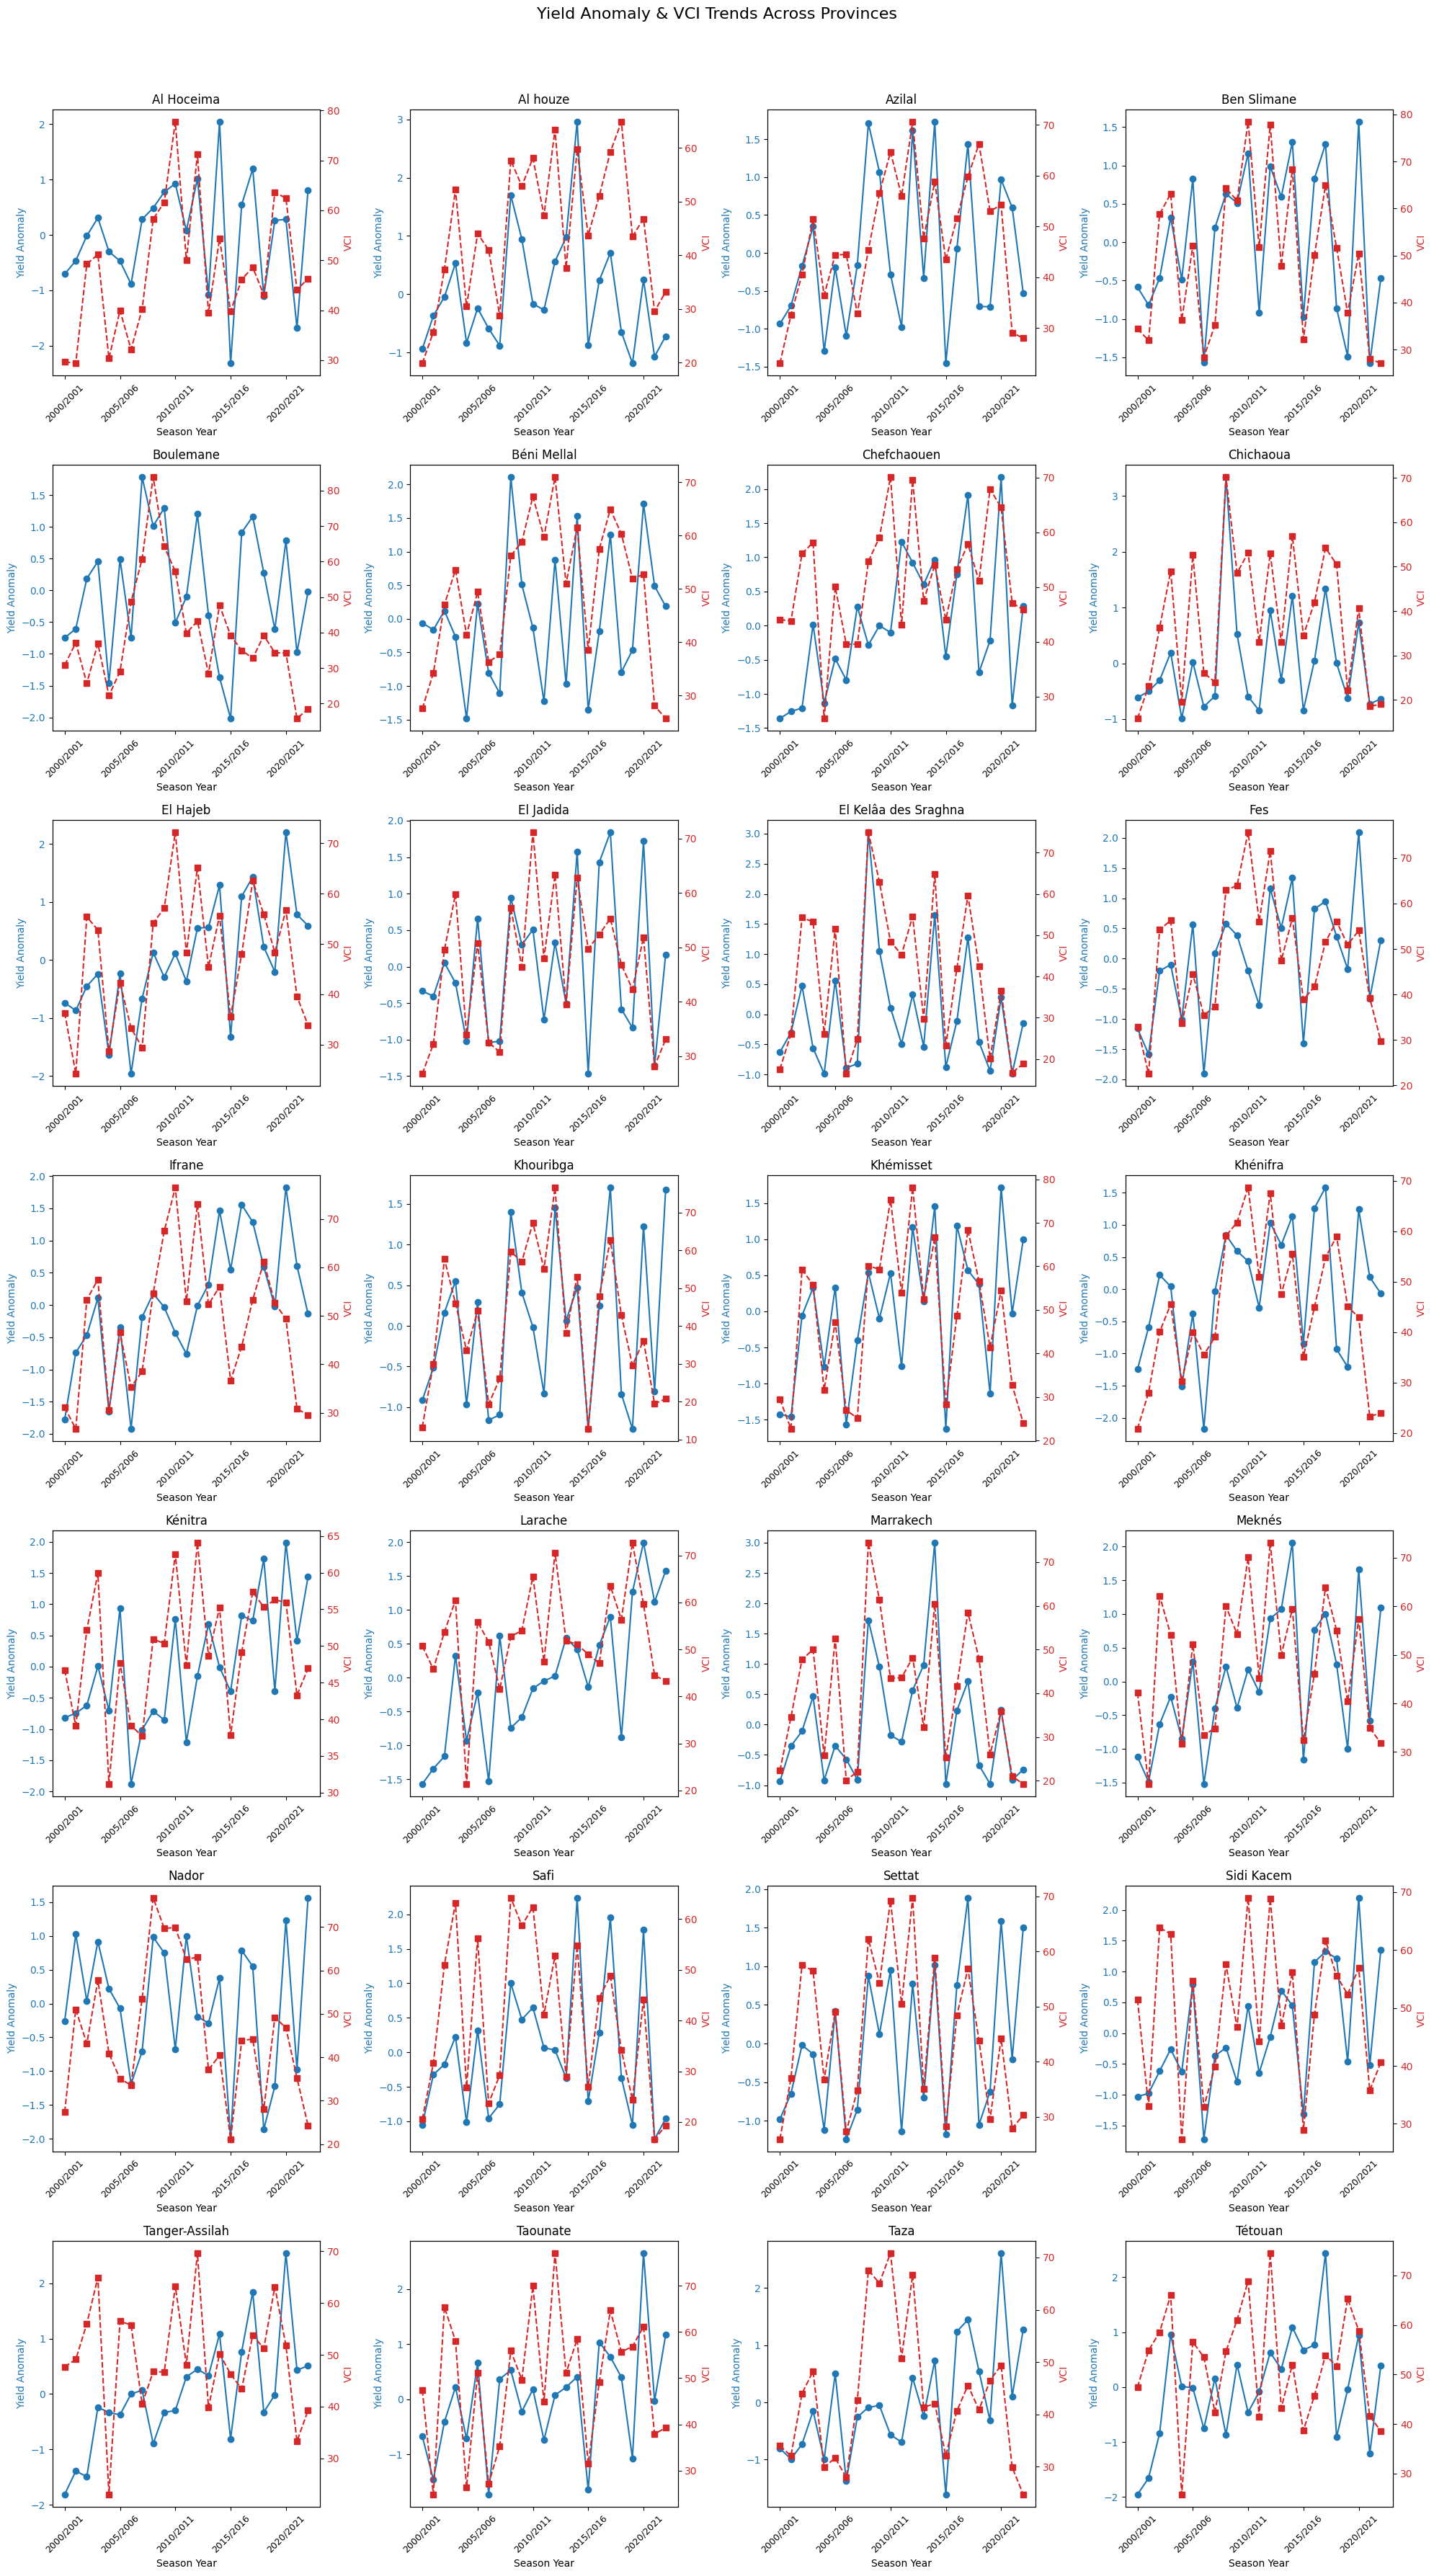

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# 1. 读取数据
# ---------------------------
yield_path = "/content/drive/MyDrive/table/Anomaly_Yield_Results.xlsx"
vci_path = "/content/drive/MyDrive/table/Seasonal_VCI_Wide.xlsx"

df_yield = pd.read_excel(yield_path).set_index('Season_Year')
df_vci = pd.read_excel(vci_path).set_index('Season_Year')

# 统一列名，去除空格，确保一致
df_yield.columns = df_yield.columns.str.strip()
df_vci.columns = df_vci.columns.str.strip()

# 获取两个表共有的省份
provinces = list(set(df_yield.columns) & set(df_vci.columns))
provinces.sort()  # 省份排序，保证图的顺序固定

# 设定时间刻度（每隔5年）
years = df_yield.index  # 获取所有年份
years_ticks = [year for year in years if int(str(year)[:4]) % 5 == 0]  # 仅保留 2000, 2005, 2010...

# ---------------------------
# 2. 绘制多子图布局
# ---------------------------
n_cols = 4  # 每行4个
n_rows = int(np.ceil(len(provinces) / n_cols))  # 计算总行数
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # 将axes转换为一维列表，方便索引

for idx, province in enumerate(provinces):
    ax1 = axes[idx]

    # 绘制Yield（左轴）
    ax1.plot(df_yield.index, df_yield[province], color='tab:blue', marker='o', linestyle='-', label='Yield Anomaly')
    ax1.set_xlabel("Season Year", fontsize=10)
    ax1.set_ylabel("Yield Anomaly", color='tab:blue', fontsize=10)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # 创建右轴并绘制VCI
    ax2 = ax1.twinx()
    ax2.plot(df_vci.index, df_vci[province], color='tab:red', marker='s', linestyle='--', label='VCI')
    ax2.set_ylabel("VCI", color='tab:red', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # 设置 x 轴刻度
    ax1.set_xticks(years_ticks)
    ax1.set_xticklabels(years_ticks, rotation=45, fontsize=9)  # 旋转45度防止重叠

    # 设置标题
    ax1.set_title(province, fontsize=12)

# 隐藏多余的空白子图
for j in range(len(provinces), len(axes)):
    axes[j].axis('off')

# 添加全局标题
plt.suptitle("Yield Anomaly & VCI Trends Across Provinces", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
